In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/argugpt/argugpt.csv
/kaggle/input/argugpt/machine-dev.csv
/kaggle/input/argugpt/machine-test.csv
/kaggle/input/argugpt/machine-train.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv


## Import Packages:

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, GRU, LSTM, TextVectorization, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

## Read Data:

In [3]:
train_prompts=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [4]:
train_essays=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [5]:
sample_submission=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
sample_submission

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [6]:
# splitting data in generated and non generated
generated=train_essays[train_essays['generated']==1]['text']
#not_generated=[]
'''
for text in train_essays['text']:
    
  if train_essays[train_essays['generated']==0]:
        generated.append(text)
        
  else:
    not_generated.append(text)
'''
generated 
        

704     This essay will analyze, discuss and prove one...
740     I strongly believe that the Electoral College ...
1262    Limiting car use causes pollution, increases c...
Name: text, dtype: object

In [7]:
# group the data frames by the prompt_id column:

# concatenate the the data frames by the second axis(, e, g columns axis=1)
concat_df=pd.concat([train_prompts, train_essays], axis=1)
# we group by prompt_id 
concat_df.drop('prompt_id', axis=1, inplace=True)
concat_df.head()
#concat_df.groupby('prompt_id')

,prompt_name,instructions,source_text,id,text,generated
0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0059830c,Cars. Cars have been around since they became ...,0
1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...,005db917,Transportation is a large necessity in most co...,0
2,NaN,NaN,NaN,008f63e3,"""America's love affair with it's vehicles seem...",0
3,NaN,NaN,NaN,00940276,How often do you ride in a car? Do you drive a...,0
4,NaN,NaN,NaN,00c39458,Cars are a wonderful thing. They are perhaps o...,0


## Data Visualizion And Feature Engineering:

In [8]:
# merge essays and prompts on prompts_id
train_data1=pd.merge(train_essays, train_prompts, on='prompt_id', how='left')
train_data1

# ==> this following code is optional but preferable
# exchange the place of the latest column('source_text') with the traget column('generated')
train_data1=train_data1[['id', 'prompt_id', 'text', 'prompt_name', 'instructions', 'source_text', 'generated']]
train_data1

,id,prompt_id,text,prompt_name,instructions,source_text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1,005db917,0,Transportation is a large necessity in most co...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
...,...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1375,ffa247e0,0,There's a new trend that has been developing f...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0


In [9]:
# the generated data ( generated from Large Language Models LLMs)
generated=train_data1[train_data1['generated']==1]
train_data1

,id,prompt_id,text,prompt_name,instructions,source_text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1,005db917,0,Transportation is a large necessity in most co...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
...,...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1375,ffa247e0,0,There's a new trend that has been developing f...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0


In [10]:
# the real data that written by student (not generated by LLMs)
not_generated=train_data1[train_data1['generated']==0]
not_generated

,id,prompt_id,text,prompt_name,instructions,source_text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1,005db917,0,Transportation is a large necessity in most co...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
...,...,...,...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1375,ffa247e0,0,There's a new trend that has been developing f...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ...",0


## Data Augumentation:

Credit
BPE Encoding based custom tokenizer by @datafan07

Ertuğrul Demir - https://www.kaggle.com/code/datafan07/train-your-own-tokenizer

Dataset: Augmented dataset by @jdragonxherrera https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/456729

In [11]:
import pandas as pd

argugpt=pd.read_csv('/kaggle/input/argugpt/argugpt.csv')
argugpt.loc[: , 'model']=1
argugpt=argugpt.iloc[:, :5]

# renaming the columns: generated <- model and instructions <- prompt 
argugpt=argugpt.rename(columns={'model': 'generated', 'prompt': 'instructions'})

# Shuffle the rows of DataFrame
argugpt=argugpt.sample(frac=1.)
argugpt
#machine_train=pd.read_csv('/kaggle/input/argugpt/machine-train.csv').iloc[:, :5].sample(frac=1.)
#machine_train

,id,prompt_id,instructions,text,generated
3292,gre_1136,GRE-633,"Any decision-whether made by government, by a ...","In today's fast-paced world, decision-making i...",1
740,weccl_3973,WECCL-21,Which skill of English is more important for C...,I think reading is more important than speakin...,1
2399,toefl_1421,TOEFL11-01,It is better to have broad knowledge of many a...,"In today's world, knowledge is power. The more...",1
2248,toefl_1206,TOEFL11-01,It is better to have broad knowledge of many a...,The debate on whether it is better to have bro...,1
2084,toefl_1013,TOEFL11-03,Young people nowadays do not give enough time ...,"In recent years, it'seems that young people ar...",1
...,...,...,...,...,...
3686,gre_538,GRE-627,Society should identify those children who hav...,I agree that society should identify those chi...,1
914,weccl_1278,WECCL-08,"In the western world, if a family member has g...",There is no one-size-fits-all answer to this q...,1
3875,toefl_531,TOEFL11-05,"In twenty years, there will be fewer cars in u...",I agree that in twenty years there will be few...,1
2851,gre_597,GRE-005,Colleges and universities should require all f...,"In today's rapidly changing world, education i...",1


In [12]:
# in the first train data we drop out the columns prompt_name source_text_id columns
#train_data1.drop(columns=['prompt_name', 'source_text'], inplace=True)
train_data1=train_data1[['id', 'prompt_id', 'instructions', 'text', 'generated']]
#train_data1=train_data.sample(frac=1)
#train_data1

# concatenate the the two dataframe
data=pd.concat([train_data1,argugpt])
data=data.sample(frac=1.)

data

,id,prompt_id,instructions,text,generated
958,weccl_1756,WECCL-08,"In the western world, if a family member has g...","It is true that in the Chinese culture, the tr...",1
1108,c9fdddd7,0,Write an explanatory essay to inform fellow ci...,Automobiles have proved to be very convenient ...,0
1982,toefl_886,TOEFL11-07,It is more important for students to understan...,There is no easy answer when it comes to the q...,1
67,0d9b0568,0,Write an explanatory essay to inform fellow ci...,Car usage all over the world has reduced and b...,0
936,weccl_1579,WECCL-08,"In the western world, if a family member has g...","In the western world, if a family member has g...",1
...,...,...,...,...,...
332,weccl_3353,WECCL-02,Some people think that education is a life-lon...,I think that education is a life-long process....,1
1331,weccl_2685,WECCL-06,Does modern technology make life more convenie...,Modern technology has undeniably made life mor...,1
3395,weccl_4253,WECCL-08,"In the western world, if a family member has g...","Recently, cancer has been the leading cause of...",1
481,5f019f6d,1,Write a letter to your state senator in which ...,"Dear senator, My associates and I, have though...",0


## Data Analysis:

In [13]:
generated=train_essays[train_essays['text']==1]
not_generated=train_essays[train_essays['text']==0]
generated
# train_essays

,id,prompt_id,text,generated


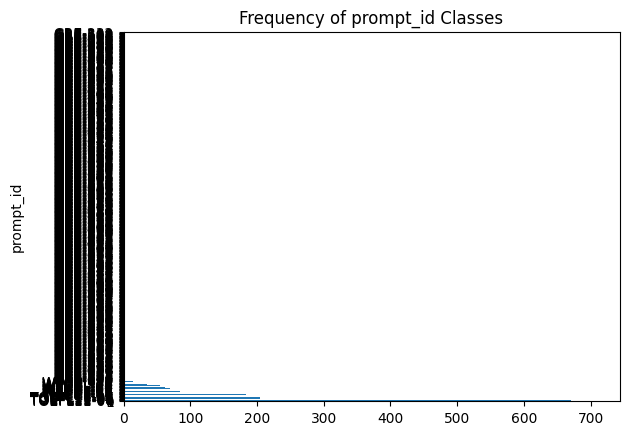

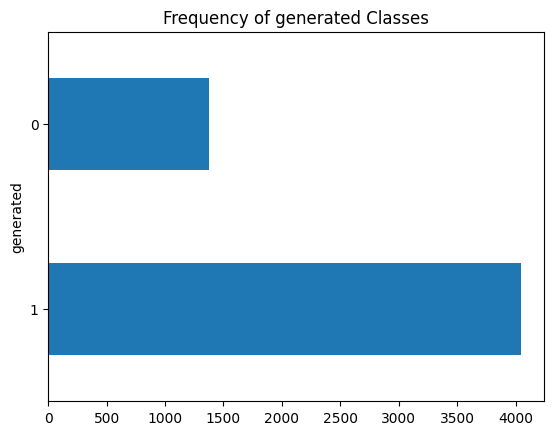

In [14]:
import matplotlib.pyplot as plt
import pandas as pd


feature_names=['prompt_id', 'generated']
for feature in feature_names:
    data[feature].value_counts(ascending=False).plot.barh()
    plt.title('Frequency of'+ ' ' +str(feature)+ ' '+'Classes')
    plt.show()

## Modeling:

## Tokeninzing The Data:

In [15]:

from keras.preprocessing.text import Tokenizer
import numpy as np
import tensorflow as tf


def preprocessing1(data):
    
    # Tokenizer nedded to transform raw texts into a sequences of tokens
    from keras.preprocessing.text import Tokenizer
    
    # the following two lines is for configuration purposes
    from tensorflow.python.ops.numpy_ops import np_config
    np_config.enable_numpy_behavior()
    
    # extracting the raw texts from the data
    texts=data['text']
  
    # convert the target pandas.Dataframe ( the lael) to np.ndarray
    y_train=data['generated'].to_numpy()
    

    # create an Tokenizer object
    tokenizer=Tokenizer()

    # train the the tolkenizer on the samples
    tokenizer.fit_on_texts(texts)

    sequences=tokenizer.texts_to_sequences(texts)
    #sequences


    X_train=tokenizer.texts_to_matrix(texts)
    
    # convert np.dtype to suitable form to convert them later in tensors
    X_train = X_train.astype(np.float32)
    y_train =y_train.astype(np.float32)
    
    # convert np.ndarray into tensors
    X_train=tf.convert_to_tensor(X_train)
    y_train=tf.convert_to_tensor(y_train)
    
    return X_train, y_train

#-------------------------------------------------------------------------


def preprocessing2(data):
    
    ##Tokenizer nedded to transform raw texts into a sequences of tokens
    from keras.preprocessing.text import Tokenizer
    
    # the following two lines is for configuration purposes
    from tensorflow.python.ops.numpy_ops import np_config
    np_config.enable_numpy_behavior()
    
    # extracting the raw texts from the data
    texts=data['text']
    

    # create an Tokenizer object
    tokenizer=Tokenizer()

    # train the the tolkenizer on the samples
    tokenizer.fit_on_texts(texts)

    sequences=tokenizer.texts_to_sequences(texts)
    #sequences

    # texts to matrix with 'tfidf' mode
    X_train=tokenizer.texts_to_matrix(texts)
    
    # convert np.dtype to suitable form to convert them later in tensors
    X_train = X_train.astype(np.float32)
    
    # convert np.ndarray into tensors
    X_train=tf.convert_to_tensor(X_train)
   
    
    return X_train







In [16]:

test=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

X_train, y_train= preprocessing1(data)#, mode='tfidf')
X_test= preprocessing2(test)#, mode='skip')

X_train=keras.preprocessing.sequence.pad_sequences(X_train)
X_test=keras.preprocessing.sequence.pad_sequences(X_test, maxlen = 23094)
X_train.shape, X_test.shape

((5416, 23094), (3, 23094))

In [17]:
X_train.shape, y_train.shape

((5416, 23094), TensorShape([5416]))

In [18]:
import keras

# build a simple model
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten

def build_model():
    
    model=Sequential(name='simple_model')

    model.add(Embedding(input_dim=200, 
                   output_dim=32
                   ,input_length=23094))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy',
                                   metrics=['accuracy'])
    
    return model

model=build_model()

# fitting the model
history=model.fit(X_train, y_train, epochs=2,  batch_size=32)

Epoch 1/2
170/170 [==============================] - 26s 149ms/step - loss: 0.6158 - accuracy: 0.9105
Epoch 2/2
170/170 [==============================] - 25s 150ms/step - loss: 0.0060 - accuracy: 0.9982


In [19]:
import pandas as pd
# the following two lines is for configuration purposes
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


preds=model.predict(X_test)
preds

#submission=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
#submission
#X_test=X_test['text'].to_numpy().astype(np.float32)

#X_test=tf.convert_to_tensor(X_test)


#preds=model.predict(X_test)
#preds.shape

#sumission=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

#submision['generated']=submision['generated'].to_numy().astypy(np.float32).convert_to_tensor(submision['generated'])
#submision['generated']=preds
#submission=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')
#submission[]
#X_test=preprocessing(test, mode='tfidf')[0]
#preds=model.predict(X_test)[:,]
#preds
#preds
#test['generated']=preds
#submission=pd.DataFrame({'id': test['id'],
#                       'generated': test['generated']})

1/1 [==============================] - 0s 100ms/step


array([[0.99987864],
       [0.9998785 ],
       [0.9998788 ]], dtype=float32)

In [20]:
'''
X_train.shape, y_train.shape
test_essays=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test_essays

###########################--------------------------##############################

# tokeninzing with keras API
from keras.preprocessing.text import Tokenizer
import numpy as np
import tensorflow as tf

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

texts=train_data1['text']
#texts

y_train=train_data1['generated'].to_numpy()

# create an Tokenizer object
tokenizer=Tokenizer()

# train the the tolkenizer on the samples
tokenizer.fit_on_texts(texts)

#sequences=tokenizer.texts_to_sequences(texts)
#sequences

# texts to matrix
X_train=tokenizer.texts_to_matrix(texts, mode='tfidf')
X_train = X_train.astype(np.float32)
y_train =y_train.astype(np.float32)

X_train=tf.convert_to_tensor(X_train)
y_train=tf.convert_to_tensor(y_train)




#########################----------------------------------#########################

X_train.shape, y_train.shape
#y_pred_proba=model.predict(X_train)
#y_pred_proba

'''

"\nX_train.shape, y_train.shape\ntest_essays=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')\ntest_essays\n\n###########################--------------------------##############################\n\n# tokeninzing with keras API\nfrom keras.preprocessing.text import Tokenizer\nimport numpy as np\nimport tensorflow as tf\n\nfrom tensorflow.python.ops.numpy_ops import np_config\nnp_config.enable_numpy_behavior()\n\ntexts=train_data1['text']\n#texts\n\ny_train=train_data1['generated'].to_numpy()\n\n# create an Tokenizer object\ntokenizer=Tokenizer()\n\n# train the the tolkenizer on the samples\ntokenizer.fit_on_texts(texts)\n\n#sequences=tokenizer.texts_to_sequences(texts)\n#sequences\n\n# texts to matrix\nX_train=tokenizer.texts_to_matrix(texts, mode='tfidf')\nX_train = X_train.astype(np.float32)\ny_train =y_train.astype(np.float32)\n\nX_train=tf.convert_to_tensor(X_train)\ny_train=tf.convert_to_tensor(y_train)\n\n\n\n\n#########################---------------------

In [21]:
'''
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(df:pd.DataFrame, target_column:str)->pd.DataFrame:
    
    # Create a TfidfVectorizer object
    vectorizer=TfidfVectorizer()
    
    # train the vectorizer on the texts and convert the result into np.ndarray
    tokenized_texts=vectorizer.fit_transform(df[target_column])
    
    # create a DataFrame of tokenized text
    tokenized_df=pd.DataFrame(tokenized_texts,  columns=vectorizer.get_feature_names())
    
    return tokenized_df

# df=tokenize(train_essays, 'text')
# df

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Input, Conv1D, MaxPooling1D, Flatten
from keras.utils import to_categorical
from keras.models import Sequential


# Define the binary classifier by Sequential keras API 
def BinaryClassifer(model_name):
    
    # Create the model 
    model=Sequential(model_name)
    model.add(Embedding(tokenizer.num_words, input_length=100))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Conv1D(units=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Falatten())
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=2, sigmoid('softmax')))
    
    # compile the model
    model.compile(loss='categoricalcrossentropy', optimizer=keras.optimizers.Adam(learning_rate=.001, metrick=['accuracy'])
    
    return model
    
 '''   

"\nimport pandas as pd\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom tensorflow.keras.preprocessing.text import Tokenizer\n\ndef tokenize(df:pd.DataFrame, target_column:str)->pd.DataFrame:\n    \n    # Create a TfidfVectorizer object\n    vectorizer=TfidfVectorizer()\n    \n    # train the vectorizer on the texts and convert the result into np.ndarray\n    tokenized_texts=vectorizer.fit_transform(df[target_column])\n    \n    # create a DataFrame of tokenized text\n    tokenized_df=pd.DataFrame(tokenized_texts,  columns=vectorizer.get_feature_names())\n    \n    return tokenized_df\n\n# df=tokenize(train_essays, 'text')\n# df\n\nfrom keras.preprocessing.text import Tokenizer\nfrom keras.preprocessing.sequence import pad_sequences\nfrom keras.layers import Embedding, LSTM, Dense, Input, Conv1D, MaxPooling1D, Flatten\nfrom keras.utils import to_categorical\nfrom keras.models import Sequential\n\n\n# Define the binary cla

## Modeling with transformers:

In [22]:
'''
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"  # Example model, you can choose other available models
model = TFAutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define input texts
texts = [
    "This is a real news article.",
    "This news is completely fake.",
    "I cannot believe this is true.",
    "The facts presented here seem accurate."
]

# Tokenize input texts
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

# Pass the encoded inputs through the model
outputs = model(**encoded_inputs)

# Access the model's output
logits = outputs.logits

# Perform classification
predictions = tf.argmax(logits, axis=1)

# Print the predictions
for text, prediction in zip(texts, predictions.numpy()):
    if prediction == 0:
        print(f"Text: {text}\nPrediction: Real\n")
    else:
        print(f"Text: {text}\nPrediction: Fake\n")

from transformers import TFAutoModel
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import tensorflow as tf

# Check if a GPU is available
gpu_available = tf.config.list_physical_devices('GPU')

# Set the device based on GPU availability
if gpu_available:
    device = tf.config.list_physical_devices('GPU')[0]
else:
    device = tf.config.list_physical_devices('CPU')[0]


# Load the pretrained tokenizer and model

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define a function to classify text as real or fake
def classify_text(text):
    # Tokenize the text
    encoded_text = tokenizer(text, truncation=True, padding=True, return_tensors='tf')

    # Predict the label
    predictions = model(**encoded_text)
    logits = predictions[0]
    predictions = tf.nn.softmax(logits, axis=-1)

    # Get the label with the highest probability
    label = tf.argmax(predictions, axis=1).numpy()[0]

    if label == 0:
        return "Real"
    else:
        return "Fake"

# Example usage
text = "This is a real piece of news."
label = classify_text(text)
print(f"Label: {label}")



#############################------------------###############################---------------------########################----------------------#######################


import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

# Load pre-trained model and tokenizer
model_name = "bert-base-uncased"  # Example model, you can choose other available models
model = TFAutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define input texts
texts = [
    "This is a real news article.",
    "This news is completely fake.",
    "I cannot believe this is true.",
    "The facts presented here seem accurate.",
    " hello everyone, my name is said koussi from morrocco", 
     "Here's an updated version of the code that includes a classification layer for obtaining the logits"
]

# Tokenize input texts
encoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")

# Pass the encoded inputs through the model
outputs = model(**encoded_inputs)

# Obtain the pooled output
pooled_output = outputs.pooler_output

# Add a classification layer
classification_layer = tf.keras.layers.Dense(2, activation='softmax')
logits = classification_layer(pooled_output)

# Perform classification
predictions = tf.argmax(logits, axis=1)

# Print the predictions
for text, prediction in zip(texts, predictions.numpy()):
    if prediction == 0:
        print(prediction, f"Text: {text}\nPrediction: Real\n")
    else:
        print(prediction, f"Text: {text}\nPrediction: Fake\n")
        
'''

'\nimport tensorflow as tf\nfrom transformers import TFAutoModel, AutoTokenizer\n\n# Load pre-trained model and tokenizer\nmodel_name = "bert-base-uncased"  # Example model, you can choose other available models\nmodel = TFAutoModel.from_pretrained(model_name)\ntokenizer = AutoTokenizer.from_pretrained(model_name)\n\n# Define input texts\ntexts = [\n    "This is a real news article.",\n    "This news is completely fake.",\n    "I cannot believe this is true.",\n    "The facts presented here seem accurate."\n]\n\n# Tokenize input texts\nencoded_inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="tf")\n\n# Pass the encoded inputs through the model\noutputs = model(**encoded_inputs)\n\n# Access the model\'s output\nlogits = outputs.logits\n\n# Perform classification\npredictions = tf.argmax(logits, axis=1)\n\n# Print the predictions\nfor text, prediction in zip(texts, predictions.numpy()):\n    if prediction == 0:\n        print(f"Text: {text}\nPrediction: Real\n")\n 

In [23]:
'''
import tensorflow as tf

# import the intersting callbacks 
from  tensorflow.keras.callbacks import EarlyStopping
from  tensorflow.keras.callbacks import ModelCheckpoint

# Define the callbacks:
early_stopping=EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint=ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                                  save_best_only=True)

# Loading the PreTrained Model:
from transformers import TFAutoModelForSequenceClassification as TFmodel

# our classifier is a binary classifier, so the number of labels is 2
# setting the parameters
num_labels=2
batch_size=32


tf_model=(TFmodel.from_pretrained(model_ckpt, num_labels=num_labels ))

# fine-tuning the model with tf.keras API

# The Column names to convert to tensorflow tensors
tf_train_dataset=train_essays['train'].to_tf_dataset[columns=tokenizer_columns,
                                                             label_cols=['label'],
                                                             shuffle=True, batch_size=batch_size]

tf_test_dataset=train_essays['validation'].to_tf_dataset[columns=tokenizer_columns,
                                                             label_cols=['label'],
                                                             shuffle=True, batch_size=batch_size]


# compile the model
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4),
                                                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                                    metrics=tf.metrics.SparseCategoricalAccuracy())

# train the model
tf_model.fit(train_data=tf_train_dataset, validation_data=tf_test_dataset, epochs=epochs, callback=[early_stopping, model_checkpoint])



'''

"\nimport tensorflow as tf\n\n# import the intersting callbacks \nfrom  tensorflow.keras.callbacks import EarlyStopping\nfrom  tensorflow.keras.callbacks import ModelCheckpoint\n\n# Define the callbacks:\nearly_stopping=EarlyStopping(monitor='val_loss', patience=3)\nmodel_checkpoint=ModelCheckpoint('best_model.h5', monitor='val_accuracy',\n                                  save_best_only=True)\n\n# Loading the PreTrained Model:\nfrom transformers import TFAutoModelForSequenceClassification as TFmodel\n\n# our classifier is a binary classifier, so the number of labels is 2\n# setting the parameters\nnum_labels=2\nbatch_size=32\n\n\ntf_model=(TFmodel.from_pretrained(model_ckpt, num_labels=num_labels ))\n\n# fine-tuning the model with tf.keras API\n\n# The Column names to convert to tensorflow tensors\ntf_train_dataset=train_essays['train'].to_tf_dataset[columns=tokenizer_columns,\n                                                             label_cols=['label'],\n                        

## Submission:

In [24]:
'''
import pandas as pd

test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test

train = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")
train.rename(columns={'label':'generated'})

external_train=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')

## concatenate the data
train=pd.concat([train, external_train])

test=pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test

vectorizer=TfidfVectorizer(ngram_range=(3, 5), tokenizer=lambda x: re.findall(r'[^\w]'),
                           token_pattern=None, strip_accents='unicode')

vectorizer.fit(test['text'])
X=vectorizer.transform(df)

'''

'\nimport pandas as pd\n\ntest = pd.read_csv(\'/kaggle/input/llm-detect-ai-generated-text/test_essays.csv\')\ntest\n\ntrain = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")\ntrain.rename(columns={\'label\':\'generated\'})\n\nexternal_train=pd.read_csv(\'/kaggle/input/llm-detect-ai-generated-text/train_essays.csv\')\n\n## concatenate the data\ntrain=pd.concat([train, external_train])\n\ntest=pd.read_csv(\'/kaggle/input/llm-detect-ai-generated-text/test_essays.csv\')\ntest\n\nvectorizer=TfidfVectorizer(ngram_range=(3, 5), tokenizer=lambda x: re.findall(r\'[^\\w]\'),\n                           token_pattern=None, strip_accents=\'unicode\')\n\nvectorizer.fit(test[\'text\'])\nX=vectorizer.transform(df)\n\n'

submission csv file take the following format:


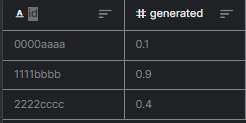

In [25]:
'''
submission=pd.DataFrame({'id': test['id'],
                         'generated': test['generated']})
'''

"\nsubmission=pd.DataFrame({'id': test['id'],\n                         'generated': test['generated']})\n"

## Submission:

In [26]:
test['generated']=preds
pd.DataFrame({'id': test['id'],
                      'generated': test['generated']}).to_csv('submission.csv', index=False)